In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

#### Functions

In [8]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [9]:
def get_responsive_pvalue(spike_times, spike_clusters, unit_ids, events, response_window=[0.002, 0.1], apply_mc_corr=True):
    wstat = np.zeros(len(unit_ids), dtype=float) * np.nan
    pvals = np.zeros(len(unit_ids), dtype=float) * np.nan
    spcounts = np.zeros(len(unit_ids), dtype=float) * np.nan
    
    for indi, uniti in enumerate(unit_ids):
        spikesi = np.squeeze(spike_times[spike_clusters == uniti])

        pre_spcounts = np.zeros(len(events), dtype=int)
        post_spcounts = np.zeros(len(events), dtype=int)
        for j, E in enumerate(events):
            pre_spcounts[j] = np.sum((spikesi >= E-response_window[1]) & (spikesi <= E-response_window[0]))
            post_spcounts[j] = np.sum((spikesi >= E+response_window[0]) & (spikesi <= E+response_window[1]))
        
#         if (post_spcounts - pre_spcounts).any():
            # stats.wilcoxon tests whether the differences x-y is symmetric about zero #
        wstat[indi], pvals[indi] = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
            # added zero-method as zsplit because many of the units have too few non-zero samples #
            # this includes the zeros in ranking, but splits them evenly between positive and negative difference ranks #
        spcounts[indi] = np.mean(post_spcounts) - np.mean(pre_spcounts)
        
    if apply_mc_corr:
#         print('Applying multiple comparisons correction...')
        rej, pvals = multitest.fdrcorrection(pvals) #, alpha=0.01) # default alpha=0.05

    return pvals, spcounts

### Define data path

In [10]:
rec_folder = r'F:\EEG_exp\mouse590480\estim_vis_2021-11-11_10-54-19\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

# comp_states = {
#     'MOs_600': {'awake': [0], 'anesthetized': [1]},
# }

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [11]:
## Make a folder in my OneDrive to save plots ##
# plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
# if not os.path.exists(plotsavedir):
#     os.mkdir(plotsavedir)
plotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\pop_rasters'
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


#### Load stim table and speed signal

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,30,318.77278,318.77318,0.0004,0,True,0.0,True
1,biphasic,30,322.64213,322.64253,0.0004,0,True,0.0,True
2,biphasic,50,326.60327,326.60367,0.0004,0,True,0.0,True
3,biphasic,70,331.08534,331.08574,0.0004,0,True,0.0,True
4,biphasic,70,334.74216,334.74256,0.0004,0,True,0.0,True


In [13]:
exp_dur = [stim_log['onset'].values[0], stim_log['onset'].values[-1]]
print(exp_dur)

[318.7727799999999, 8223.39195]


In [14]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

## Get bad_ch_list from metadata ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))

['30', '50', '70']
50


#### Load EEG data

#### Load unit data

In [15]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [16]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['units'] = all_units
    probe_unit_data[probei]['chs'] = all_units_chs
    probe_unit_data[probei]['cell_type'] = all_units_types
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['areas'] = all_units_areas
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 351
 unit count: 258
probeC
 surface channel: 350
 unit count: 305
probeF
 surface channel: 354
 unit count: 385
Total unit count: 948


## Get population spike times to plot SDF across trial

In [17]:
alpha = 0.01

In [18]:
pop_spike_times = {key: [] for key in areas_of_interest}
pop_unit_depths = {key: [] for key in areas_of_interest}
for probei, unit_data in probe_unit_data.items():
    ## Get trial spikes for each unit ##
    for unitind, uniti in enumerate(unit_data['units']):
        spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
        parent_region = [
            key for key in areas_of_interest if unit_data['areas'][unitind] in areas_of_interest[key]
        ]
        if len(parent_region) == 1:
            pop_spike_times[parent_region[0]].append(spikesi)
            pop_unit_depths[parent_region[0]].append(unit_data['ch_depths'][unit_data['chs'][unitind]])

In [19]:
time_bin = 0.005 # spike histogram bin size (s)
bins = np.arange(exp_dur[0], exp_dur[1] + 5, time_bin)
gausswin = 0.05 # duration of convolution (s)

pop_SDF = {}
pop_num_units = {}
for region, pspiketimes in pop_spike_times.items():
    print(region)
    pop_num_units[region] = len(pspiketimes)
    if len(pspiketimes) > 0:
        pspiketimes = np.concatenate(pspiketimes)
        print(' {:d} population spikes'.format(len(pspiketimes)))
    else:
        print(' 0 population spikes :(')
        continue
    
    ## Bin population spikes for whole experiment and get SDF ##
    pop_counts, edges = np.histogram(pspiketimes, bins)
    pop_SDF[region] = (
        ndimage.gaussian_filter(pop_counts, sigma=int(gausswin / time_bin), output=float) / (time_bin * pop_num_units[region]))

MO
 2311876 population spikes
ACA
 2169297 population spikes
SS
 2904059 population spikes
VIS
 1920621 population spikes
MO-TH
 3325967 population spikes


In [23]:
exp_dur[0]

326.2319

Plotting spikes/SDF/behavioral data

In [23]:
stim_log[stim_log['sweep'] == 1].head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
480,biphasic,30,2429.47265,2429.47305,0.0004,1,True,0.000000,True
481,biphasic,30,2433.34199,2433.34239,0.0004,1,True,0.000000,True
482,biphasic,50,2437.30313,2437.30353,0.0004,1,True,0.000000,True
483,biphasic,70,2441.78520,2441.78560,0.0004,1,True,0.000000,True
484,biphasic,70,2445.44202,2445.44242,0.0004,1,True,4.191449,False


In [21]:
currents_list
currentcolors = {x: y for x, y in zip(currents_list, ['gold', 'orange', 'red'])}

<IPython.core.display.Javascript object>


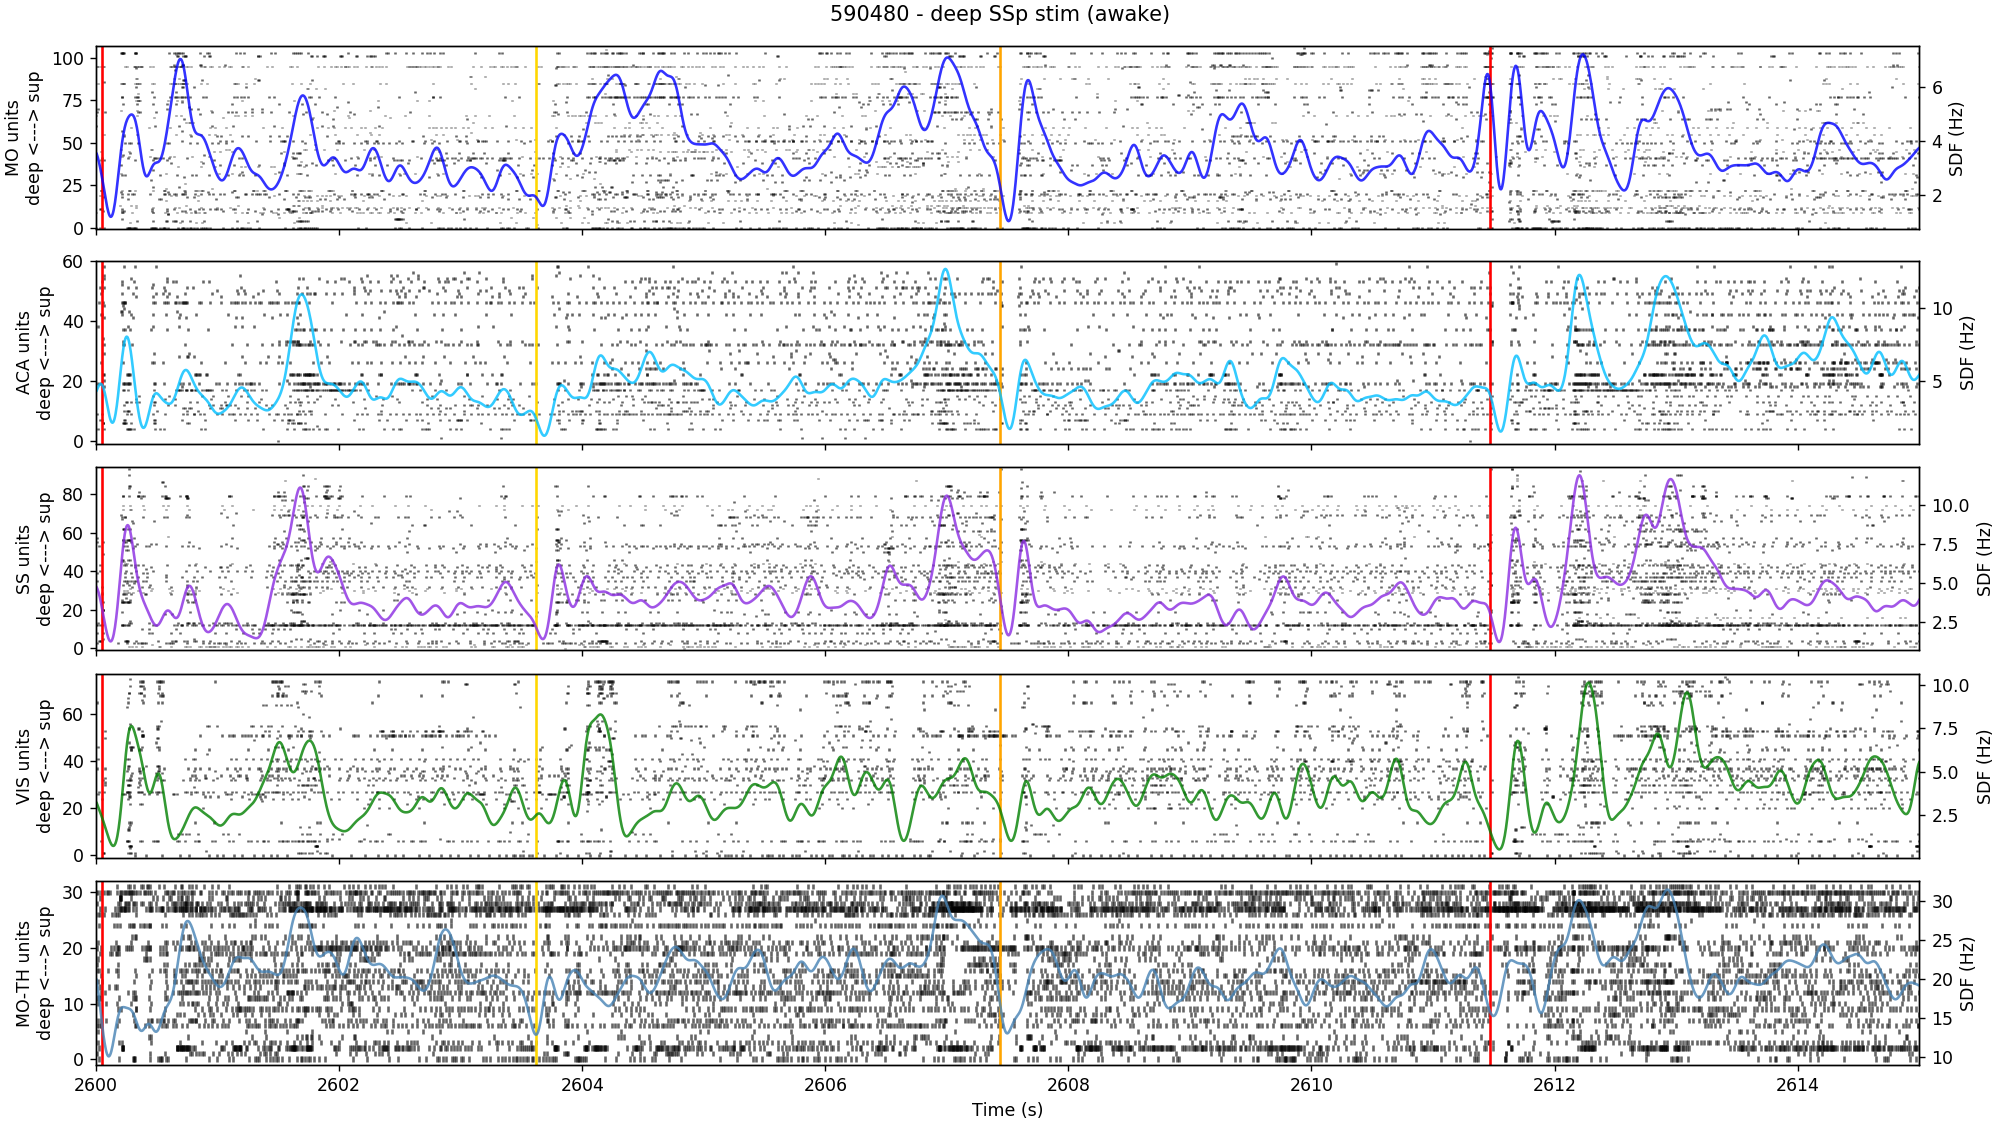

In [24]:
ROIs = ['MO', 'ACA', 'SS', 'VIS', 'MO-TH']

pwin = [2600.0, 2615.0] # [500.0, 515.0] [2550.0, 2565.0]

stim_onsets = stim_log['onset'].values
stim_vals = stim_log['parameter'].values
stiminds = np.nonzero((stim_onsets > pwin[0]) & (stim_onsets < pwin[1]))[0]


bininds = np.nonzero((bins[:-1] > pwin[0]) & (bins[:-1] < pwin[1]))[0]
fig, axs = plt.subplots(len(ROIs), figsize=(16,9), sharex= True, constrained_layout=True)
for ax, region in zip(axs, ROIs):
    for indi, unitind in enumerate(np.squeeze(np.argsort(pop_unit_depths[region]))[::-1]):
        spinds = np.nonzero((pop_spike_times[region][unitind] > pwin[0]) & (pop_spike_times[region][unitind] < pwin[1]))[0]
        ax.eventplot(pop_spike_times[region][unitind][spinds], lineoffsets=indi, linelengths=0.95, color='k', alpha=0.6)
    ax.set_ylim([-1, indi+1])
    ax.set_ylabel('{} units\ndeep <---> sup'.format(region))
    for stimi in stiminds:
        ax.axvline(stim_onsets[stimi], color=currentcolors[stim_vals[stimi]])
    sdfax = ax.twinx()
    sdfax.plot((bins[:-1] + time_bin / 2)[bininds], pop_SDF[region][bininds], color=area_colors[region], alpha=0.8)
    sdfax.set_ylabel('SDF (Hz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(pwin)

plt.suptitle('{} - deep SSp stim (awake)'.format(exp.mouse))

## Save ##
figname = '{}_rasterSDF_awake_deepSS.png'.format(exp.mouse)
fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

<IPython.core.display.Javascript object>


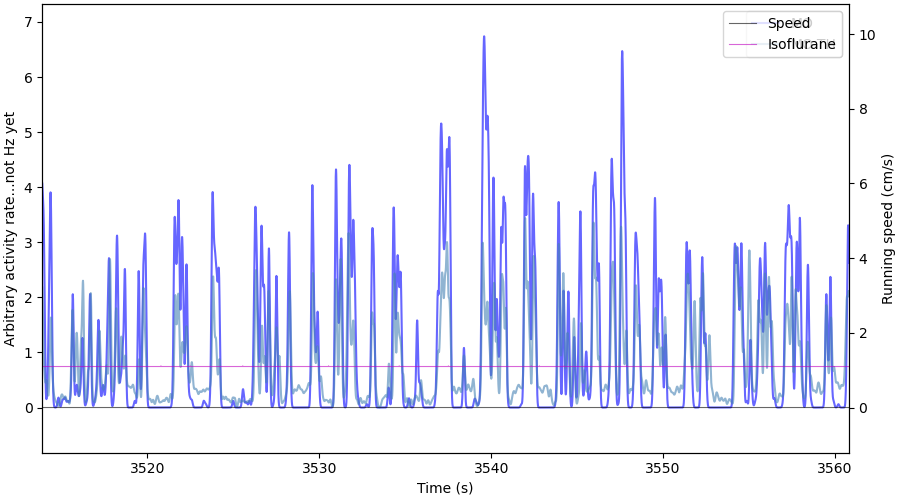

In [94]:
ROIs = ['MO', 'MO-TH']
fig, ax = plt.subplots(figsize=(9,5), constrained_layout=True)
for region in ROIs:
    ax.plot(bins[:-1] + time_bin / 2, pop_SDF[region], color=area_colors[region], alpha=0.6, label=region)
ax.set_ylabel('Arbitrary activity rate...not Hz yet')
ax.set_xlabel('Time (s)')
ax.set_xlim(exp_dur)
ax.legend()

runax = ax.twinx()
runax.plot(run_timestamps, run_signal, color='k', linewidth=0.8, alpha=0.6, label='Speed')
runax.set_ylabel('Running speed (cm/s)')
runax.plot(iso_timestamps, iso_signal, color='m', linewidth=0.8, alpha=0.6, label='Isoflurane')
runax.legend()

### How to identify bursts?

3232


<IPython.core.display.Javascript object>


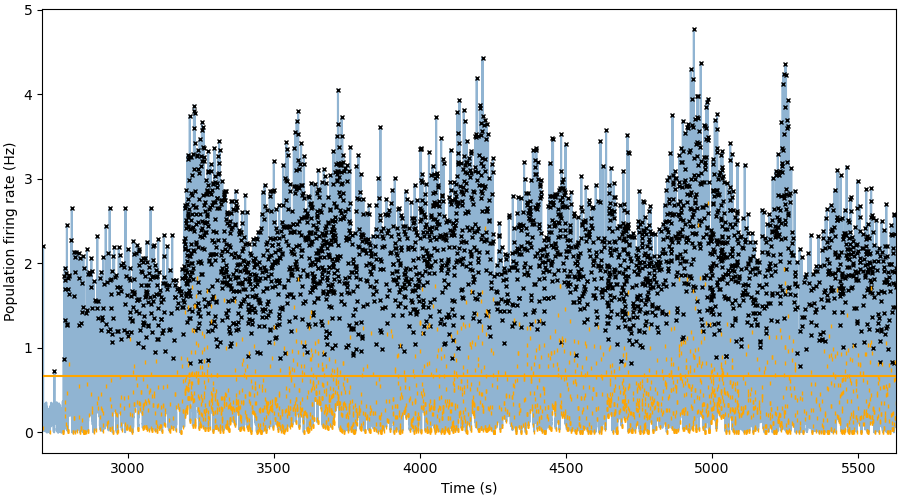

(2707.04, 5628.72)

In [144]:
ROI = 'MO-TH'
bininds = np.nonzero((bins[:-1] > maintenance[0]) & (bins[:-1] < maintenance[1]))[0]
timex = (bins[:-1] + time_bin / 2)[bininds]
sdf = pop_SDF[ROI][bininds]
threshold = np.std(sdf)
peaks, pprops = signal.find_peaks(sdf, prominence=threshold)#, distance=int(0.5/time_bin))
print(len(peaks))

fig, ax = plt.subplots(figsize=(9,5), constrained_layout=True)
ax.plot(timex, sdf, color=area_colors[ROI], alpha=0.6, label=ROI)
ax.axhline(threshold, color='orange')
ax.plot(timex[peaks], sdf[peaks], c='k', marker='x', linestyle='none', markersize=3)
ax.plot(timex[pprops['left_bases']], sdf[pprops['left_bases']], c='orange', marker='|', linestyle='none', markersize=3)
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(maintenance)

In [145]:
best_peaks = []
best_lefts = []
best_rights = []
i = 0
while i <= len(peaks)-2:
    dip = np.sum(sdf[peaks[i]:peaks[i+1]] <= 0.01)
    pp, lb, rb = [peaks[i]], [pprops['left_bases'][i]], [pprops['right_bases'][i]]
    while dip < 15:
        i += 1
        pp.append(peaks[i])
        lb.append(pprops['left_bases'][i])
        rb.append(pprops['right_bases'][i])
        if i == len(peaks)-1:
            best_peaks.append(pp[np.argmax(sdf[pp])])
            best_lefts.append(min(lb))
            best_rights.append(max(rb))
            break
        dip = np.sum(sdf[peaks[i]:peaks[i+1]] <= 0.01)
    else:
        best_peaks.append(pp[np.argmax(sdf[pp])])
        best_lefts.append(min(lb))
        best_rights.append(max(rb))
        i += 1
else:
    best_peaks.append(peaks[i])
    best_lefts.append(pprops['left_bases'][i])
    best_rights.append(pprops['right_bases'][i])
best_peaks = np.array(best_peaks)
best_lefts = np.array(best_lefts)
best_rights = np.array(best_rights)

<IPython.core.display.Javascript object>


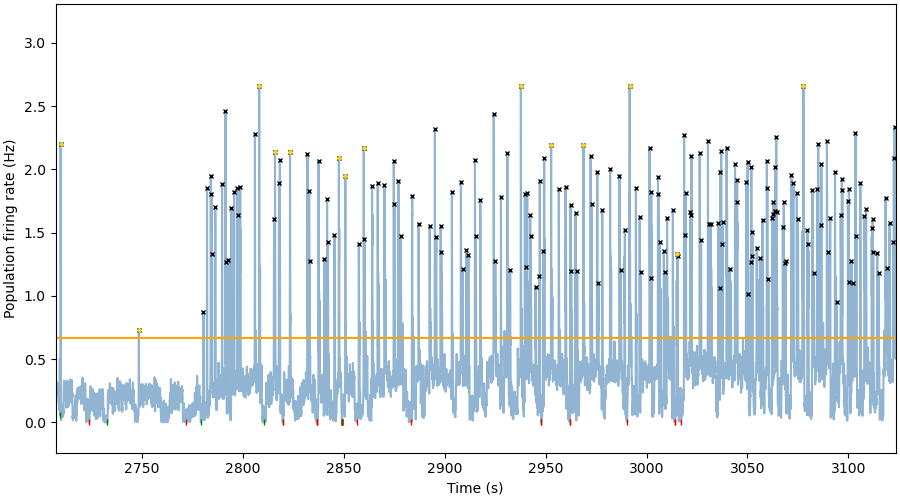

(2707.04, 5628.72)

In [146]:
# ROI = 'MO'
# bininds = np.nonzero((bins[:-1] > maintenance[0]) & (bins[:-1] < maintenance[1]))[0]
# timex = (bins[:-1] + time_bin / 2)[bininds]
# sdf = pop_SDF[ROI][bininds]
# threshold = np.std(sdf)

fig, ax = plt.subplots(figsize=(9,5), constrained_layout=True)
ax.plot(timex, sdf, color=area_colors[ROI], alpha=0.6, label=ROI)
ax.axhline(threshold, color='orange')
ax.plot(timex[peaks], sdf[peaks], c='k', marker='x', linestyle='none', markersize=3)
ax.plot(timex[best_peaks], sdf[best_peaks], c='gold', marker='o', linestyle='none', markersize=2)
ax.plot(timex[best_lefts], sdf[best_lefts], c='green', marker='|', linestyle='none', markersize=5)
ax.plot(timex[best_rights], sdf[best_rights], c='red', marker='|', linestyle='none', markersize=5)
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(maintenance)

In [88]:
peaks_copy = peaks
print('Original peaks found: {:d}'.format(len(peaks)))
for iteri in range(10):
    first_pwins = np.zeros(len(peaks_copy))
    first_pwins[-1] = 1 # set final peak to 1 because it won't get tested as a 1st peak
    second_pwins = np.zeros(len(peaks_copy))
    second_pwins[0] = 1 # set 1st peak to 1 because it won't get tested as a 2nd peak
    for ii in range(len(peaks_copy)-1):
        first = peaks_copy[ii]
        second = peaks_copy[ii+1]
        if np.sum(sdf[first:second] <= 0.01) < 10: # if the peaks do not have a dip between them, choose the higher one
            if sdf[first] > sdf[second]:
                first_pwins[ii] = 1
            else:
                second_pwins[ii+1] = 1
        else: # if the peaks do have a dip between them, keep both
            first_pwins[ii] = 1
            second_pwins[ii+1] = 1
    peak_mask = (first_pwins * second_pwins).astype('bool')
    peaks_copy = peaks_copy[peak_mask]
    print('Iteration {:d}: {:d} peaks'.format(iteri, len(peaks_copy)))

Original peaks found: 4590
Iteration 0: 1819 peaks
Iteration 1: 1125 peaks
Iteration 2: 995 peaks
Iteration 3: 974 peaks
Iteration 4: 969 peaks
Iteration 5: 969 peaks
Iteration 6: 969 peaks
Iteration 7: 969 peaks
Iteration 8: 969 peaks
Iteration 9: 969 peaks


<IPython.core.display.Javascript object>


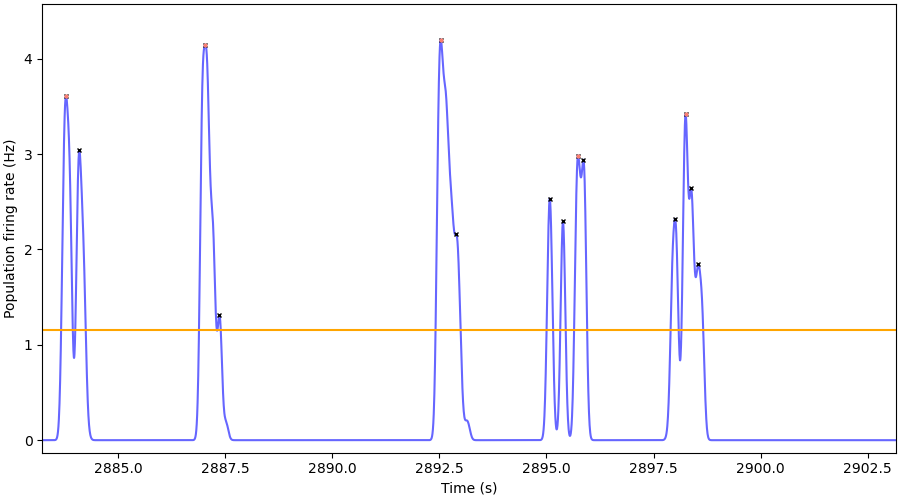

(2707.04, 5628.72)

In [89]:
ROI = 'MO'
bininds = np.nonzero((bins[:-1] > maintenance[0]) & (bins[:-1] < maintenance[1]))[0]
timex = (bins[:-1] + time_bin / 2)[bininds]
sdf = pop_SDF[ROI][bininds]
threshold = np.std(sdf)

fig, ax = plt.subplots(figsize=(9,5), constrained_layout=True)
ax.plot(timex, sdf, color=area_colors[ROI], alpha=0.6, label=ROI)
ax.axhline(threshold, color='orange')
ax.plot(timex[peaks], sdf[peaks], c='k', marker='x', linestyle='none', markersize=3)
ax.plot(timex[peaks_copy], sdf[peaks_copy], c='salmon', marker='o', linestyle='none', markersize=2)
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(maintenance)

## Plot SDF, LFP, and EEG together

Let's get LFP, but only for probe F.

## Get trial times

In [18]:
rest_trials_only = True
all_event_times = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    for parami in currents_list:
        print('biphasic - {} \u03bcA'.format(parami))
        all_event_times[expdes][parami] = {}
        for statei, sweeps in state_sweeps.items():
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            if rest_trials_only:
                all_event_times[expdes][parami][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][parami][statei] = state_events

MOs_1200
biphasic - 15 μA
 awake state: resting trials 94/120
 anesthetized state: resting trials 120/120
biphasic - 35 μA
 awake state: resting trials 102/120
 anesthetized state: resting trials 119/120
biphasic - 60 μA
 awake state: resting trials 90/120
 anesthetized state: resting trials 120/120


### Categorize responsive units

In [19]:
raster_window = [-1.0, 1.0]
spcount_window = [0.002, 0.025] # [0.002, 0.025] [0.025, 0.125]
alpha = 0.05

In [20]:
unit_trial_spikes = {}
unit_responses = {}
for expdes in all_event_times.keys():
    unit_trial_spikes[expdes] = {}
    unit_responses[expdes] = {}
    for parami, statesevents in all_event_times[expdes].items():
        unit_trial_spikes[expdes][parami] = {}
        unit_responses[expdes][parami] = {}
        for statei, events in statesevents.items():
            unit_trial_spikes[expdes][parami][statei] = {}
            ## Loop through probes to get unit responsiveness ##
            units_list = []
            areas_list = []
            parents_list = []
            depths_list = []
            types_list = []
            response_list = []
            for probei, unit_data in probe_unit_data.items():
                ## Get trial spikes for each unit ##
                for unitind, uniti in enumerate(unit_data['units']):
                    spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
                    event_raster = []
                    for eventi in events:
                        spikeinds = np.squeeze(
                            np.argwhere((spikesi > eventi + raster_window[0]) & (spikesi < eventi + raster_window[1]))
                        )
                        event_raster.append(spikesi[spikeinds] - eventi)
                    unit_trial_spikes[expdes][parami][statei][probei[-1] + str(uniti)] = event_raster
                ## Get responsiveness ##
                unit_ids = [probei[-1] + str(x) for x in unit_data['units']]
                unit_pvals, unit_spcounts = get_responsive_pvalue(
                    unit_data['spike_times'],
                    unit_data['spike_clusters'],
                    unit_data['units'],
                    events,
                    spcount_window,
                )

                ## Loop through all units and add to the correct population ##
                probe_parent_list = []
                probe_response_list = []
#                 probe_unit_depths = []
                for unitind in range(unit_pvals.shape[0]):
                    parent_region = [
                        key for key in list(areas_of_interest.keys()) if unit_data['areas'][unitind] in areas_of_interest[key]
                    ]
#                     probe_unit_depths.append(unit_data['ch_depths'][unit_data['chs'][unitind]])
                    if unit_pvals[unitind] < alpha and unit_spcounts[unitind] > 0:
                        probe_response_list.append('excited')
                    elif unit_pvals[unitind] < alpha and unit_spcounts[unitind] < 0:
                        probe_response_list.append('inhibited')
                    else:
                        probe_response_list.append('ns')
                    if len(parent_region) == 1:
                        probe_parent_list.append(parent_region[0])
                    else:
                        probe_parent_list.append('none')

                units_list.append(unit_ids)
                areas_list.append(unit_data['areas'])
                parents_list.append(probe_parent_list)
                depths_list.append(unit_data['ch_depths'][unit_data['chs']])
                types_list.append(unit_data['cell_type'])
                response_list.append(probe_response_list)

            ## Make a dataframe with all of the unit data
            unit_responses[expdes][parami][statei] = pd.DataFrame({
                    'unit_id': np.concatenate(units_list),
                    'area': np.concatenate(areas_list),
                    'parent': np.concatenate(parents_list),
                    'unit_depths': np.concatenate(depths_list),
                    'cell_type': np.concatenate(types_list),
                    'response': np.concatenate(response_list),
                })

### Examine different aspects of timing in populations and responsive cells.

In [135]:
ROI = ['MO', 'MO-TH']
plot_cell_type = 'RS'
plot_response_type = 'excited'
plexp = 'MOs_1200'
plstim = '35'
plstate = 'awake' # 'anesthetized' 'awake'

Compare latency to first spike in responsive units for a single subject and trial type. Could also include:
- probability of eliciting a first spike
- baseline firing rate of each cell

<IPython.core.display.Javascript object>


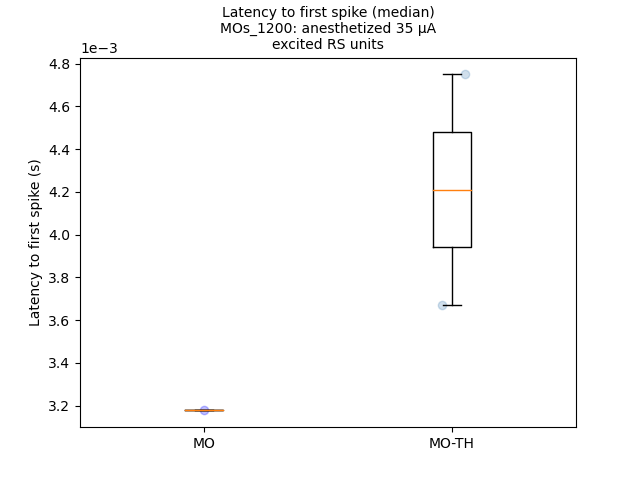

In [119]:
df = unit_responses[plexp][plstim][plstate]
pop_median_first_spikes = {}
for region in ROI:
    UOI = df[(
        (df['parent'] == region) &
        (df['cell_type'] == plot_cell_type) &
        (df['response'] == plot_response_type)
    )].unit_id.values
    all_units_first_spikes = []
    for uniti in UOI:
        first_spikes = []
        for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
            if not isinstance(spikes, np.ndarray):
                spikes = np.array([spikes])
            early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
            if len(early_spikes) > 0:
                first_spikes.append(spikes[early_spikes[0]])
        all_units_first_spikes.append(np.median(first_spikes))
    pop_median_first_spikes[region] = np.array(all_units_first_spikes)

## Mann-Whitney U test ##
U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
    ax.boxplot(medfspikes, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(medfspikes))
    ax.scatter(xs, medfspikes, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_median_first_spikes.keys())
ax.set_ylabel('Latency to first spike (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to first spike (median)\n{}: {} {} \u03bcA\n{} {} units'.format(
    plexp, plstate, plstim, plot_response_type, plot_cell_type
))

## Save ##
figname = 'Latency_1stspike_{}_{}{}_{}{}.png'.format(exp.mouse, plstate, plstim, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Repeat for all cells in population, not just excited RS.

<IPython.core.display.Javascript object>


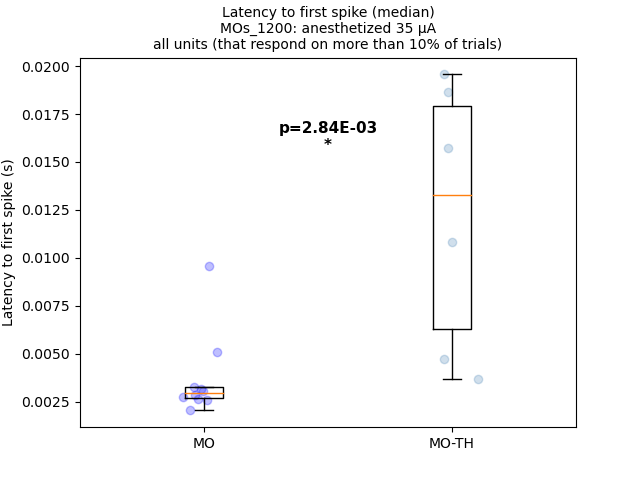

In [120]:
trialnumthresh = len(all_event_times[plexp][plstim][plstate]) * 0.1

df = unit_responses[plexp][plstim][plstate]
pop_median_first_spikes = {}
for region in ROI:
    UOI = df[df['parent'] == region].unit_id.values
    all_units_first_spikes = []
    for uniti in UOI:
        first_spikes = []
        for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
            if not isinstance(spikes, np.ndarray):
                spikes = np.array([spikes])
            early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
            if len(early_spikes) > 0:
                first_spikes.append(spikes[early_spikes[0]])
        if len(first_spikes) > trialnumthresh:
            all_units_first_spikes.append(np.median(first_spikes))
    pop_median_first_spikes[region] = np.array(all_units_first_spikes)

## Mann-Whitney U test ##
U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
    ax.boxplot(medfspikes, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(medfspikes))
    ax.scatter(xs, medfspikes, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_median_first_spikes.keys())
ax.set_ylabel('Latency to first spike (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to first spike (median)\n{}: {} {} \u03bcA\nall units (that respond on more than 10% of trials)'.format(
    plexp, plstate, plstim
))

## Save ##
figname = 'Latency_1stspike_{}_{}{}_allunits.png'.format(exp.mouse, plstate, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

<IPython.core.display.Javascript object>


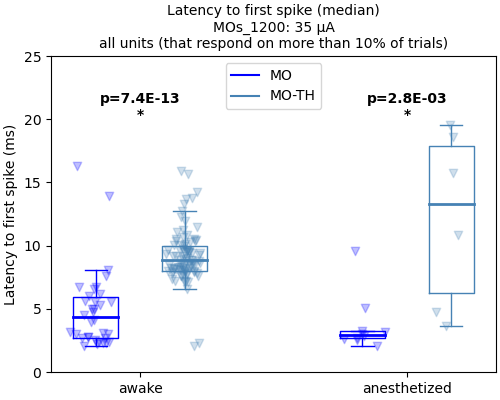

In [174]:
trialnumthresh = len(all_event_times[plexp][plstim][statei]) * 0.1
dualstates = ['awake', 'anesthetized']
catx = np.arange(0,len(dualstates)*2, len(dualstates)+1)

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
for si, statei in enumerate(dualstates):
    df = unit_responses[plexp][plstim][statei]
    pop_median_first_spikes = {}
    for region in ROI:
        UOI = df[df['parent'] == region].unit_id.values
        all_units_first_spikes = []
        for uniti in UOI:
            first_spikes = []
            for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][statei][uniti]):
                if not isinstance(spikes, np.ndarray):
                    spikes = np.array([spikes])
                early_spikes = np.nonzero((spikes > 0) & (spikes < spcount_window[1]))[0]
                if len(early_spikes) > 0:
                    first_spikes.append(spikes[early_spikes[0]])
            if len(first_spikes) > trialnumthresh:
                all_units_first_spikes.append(np.median(first_spikes))
        pop_median_first_spikes[region] = np.array(all_units_first_spikes)

    ## Mann-Whitney U test ##
    U, pval = stats.mannwhitneyu(pop_median_first_spikes['MO'], pop_median_first_spikes['MO-TH'], alternative='less')

    ## Plot it ##
    x = catx[si] + np.arange(len(pop_median_first_spikes))
    for ii, (region, medfspikes) in enumerate(pop_median_first_spikes.items()):
        bpl = ax.boxplot(
            medfspikes*1E3, positions=[x[ii]], showfliers=False, widths=0.5,
            boxprops={'color': area_colors[region]},
            capprops={'color': area_colors[region]},
            whiskerprops={'color': area_colors[region]},
            medianprops={'color': area_colors[region], 'linewidth': 2},
        )
        xs = np.random.normal(ii, 0.1, len(medfspikes)) + catx[si]
        ax.scatter(xs, medfspikes*1E3, c=area_colors[region], marker='v', alpha=0.25)
    # annotate with asterisk
    if pval < 0.01:
        ax.annotate(
            'p={:.1E}\n*'.format(pval), xy=(np.mean(x), 20), xycoords='data', fontsize=10, fontweight='bold', ha='center')
    ax.set_title(
        'Latency to first spike (median)\n{}: {} \u03bcA\nall units (that respond on more than 10% of trials)'.format(
        plexp, plstim
    ))
ax.set_xticks(catx + 0.5)
ax.set_xticklabels(dualstates)
ax.set_ylim([0, spcount_window[1]*1E3])
ax.set_ylabel('Latency to first spike (ms)')

## Make legend ##
for region in ROI:
    ax.plot([], c=area_colors[region], label=region)
ax.legend(loc='upper center')

## Save ##
figname = 'Latency_1stspike_compstates_{}_{}_allunits.png'.format(exp.mouse, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Plot population rasters for single trials. To do: a subplot for only responsive units?

In [136]:
peak_windows = {'early': [0.0, 0.025], 'late': [0.025, 0.225]}
time_bin = 0.001 # size of time bins (s)
gausswin = 0.005 # duration of convolution (s)

df = unit_responses[plexp][plstim][plstate]
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)

In [137]:
pop_peak_latency = {
    keyw: {keyr: np.zeros(len(all_event_times[plexp][plstim][plstate]), dtype=float) for keyr in ROI} for keyw in peak_windows
}
for coli, region in enumerate(ROI):
    select_units = df[df['parent'] == region].unit_id.values
    
    for triali in range(len(all_event_times[plexp][plstim][plstate])):
        pop_hist = []
        for indi, uniti in enumerate(select_units):
            pop_counts, edges = np.histogram(unit_trial_spikes[plexp][plstim][plstate][uniti][triali], bins)
            pop_hist.append(pop_counts)
        pop_bin_counts = np.sum(np.array(pop_hist), axis=0)
        popSDF = ndimage.gaussian_filter(pop_bin_counts, sigma=int(gausswin / time_bin), output=float)
        for tt, win in peak_windows.items():
            wininds = np.nonzero((bins >= win[0]) & (bins <= win[1]))[0]
            pop_peak_latency[tt][region][triali] = bins[wininds][np.argmax(popSDF[wininds])]

Plot scatter plot of pop SDF peak latencies for all trials.

<IPython.core.display.Javascript object>


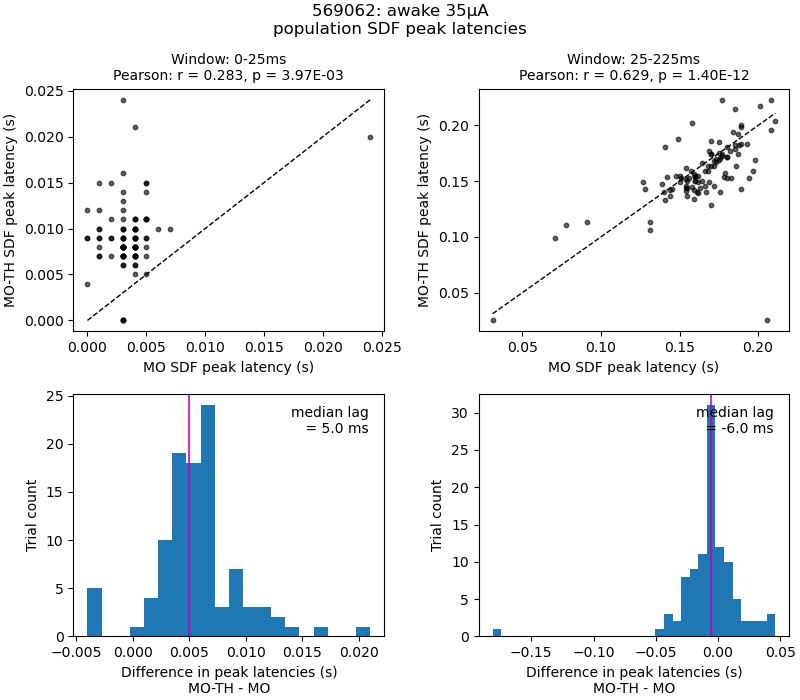

In [175]:
fig, axs = plt.subplots(2, len(pop_peak_latency), figsize=(8,7), constrained_layout=True)

for ii, (tt, win) in enumerate(peak_windows.items()):
    latencies = []
    labels = []
    for region, vals in pop_peak_latency[tt].items():
        latencies.append(vals)
        labels.append(region)
    pearson_r, pearson_p = stats.pearsonr(latencies[0], latencies[1])
    axs[0,ii].scatter(latencies[0], latencies[1], c='k', s=10, alpha=0.6)
    minx = np.min(latencies[0])
    maxx = np.max(latencies[0])
    axs[0,ii].plot([minx, maxx], [minx, maxx], 'k', linewidth=1, linestyle='dashed')
    axs[0,ii].set_xlabel('{} SDF peak latency (s)'.format(labels[0]))
    axs[0,ii].set_ylabel('{} SDF peak latency (s)'.format(labels[1]))
    axs[0,ii].set_title('Window: {:d}-{:d}ms\nPearson: r = {:.3f}, p = {:.2E}'.format(
        int(win[0]*1E3), int(win[1]*1E3), pearson_r, pearson_p))
    
    peak_lags = latencies[1] - latencies[0]
    axs[1,ii].hist(peak_lags)
    axs[1,ii].axvline(np.median(peak_lags), color='m', alpha=0.8)
    axs[1,ii].text(
            0.95, 0.95, 'median lag\n = {:.1f} ms'.format(np.median(peak_lags)*1E3),
            ha='right', va='top', transform=axs[1,ii].transAxes, fontsize=10
        )
    axs[1,ii].set_xlabel('Difference in peak latencies (s)\n{} - {}'.format(labels[1], labels[0]))
    axs[1,ii].set_ylabel('Trial count')
plt.suptitle('{}: {} {}\u03bcA\npopulation SDF peak latencies'.format(exp.mouse, plstate, plstim), fontsize=12)
## Save ##
figname = 'allPOP_peakSDF_scatter_{}_{}{}.png'.format(exp.mouse, plstate, plstim)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)

Plot trial 2nd peak latencies for populations

9.495278686965936e-28


<IPython.core.display.Javascript object>


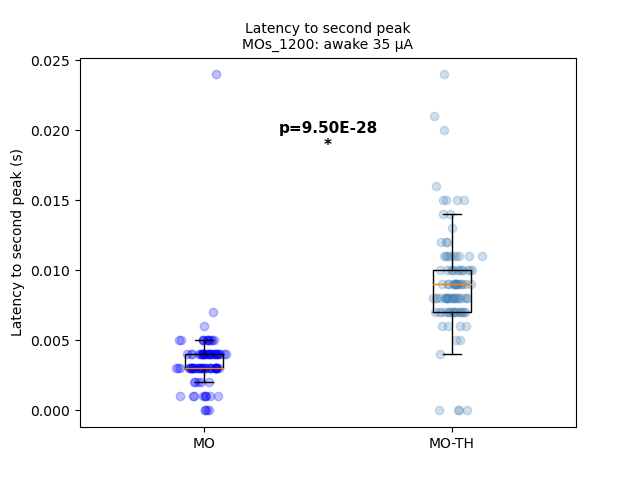

In [139]:
pwin = 'late'
# pop_peak_latency[pwin]
## Mann-Whitney U test ##
# U, pval = stats.mannwhitneyu(pop_peak_latency[pwin]['MO'], pop_peak_latency[pwin]['MO-TH'], alternative='greater')

## Paired t-test ##
pairedt, p2 = stats.ttest_rel(pop_peak_latency[pwin]['MO'], pop_peak_latency[pwin]['MO-TH'], nan_policy='omit')
pval = p2 / 2
print(pval)

## Plot it ##
fig, ax = plt.subplots()
x = np.arange(len(pop_median_first_spikes))
for ii, (region, peaklats) in enumerate(pop_peak_latency[pwin].items()):
    ax.boxplot(peaklats, positions=[x[ii]], showfliers=False)
    xs = np.random.normal(ii, 0.04, len(peaklats))
    ax.scatter(xs, peaklats, c=area_colors[region], alpha=0.25)
ax.set_xticklabels(pop_peak_latency[pwin].keys())
ax.set_ylabel('Latency to second peak (s)')
# annotate with asterisk
if pval < 0.01:
    ax.annotate(
        'p={:.2E}\n*'.format(pval), xy=(0.5, 0.75), xycoords='axes fraction', fontsize=11, fontweight='bold', ha='center')
ax.set_title('Latency to second peak\n{}: {} {} \u03bcA'.format(plexp, plstate, plstim))

## Save ##
figname = 'Latency_2ndpeak_{}_{}{}_allunits_trials.png'.format(exp.mouse, plstate, plstim, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(figsavedir, figname), transparent=True)